In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
import albumentations as A
from sklearn.svm import SVC
from random import random
from pathlib import Path
from tqdm import tqdm
import numpy as np
import math
import cv2
import os

In [ ]:
A.seed_everything(42)

np.random.seed(42)
random.seed(42)

In [41]:
#declare variables and create augmented directories
dataset_path = "../dataset"
n_augmented_class=500
image_size = (224, 224)
classes = ["glass", "paper", "cardboard", "plastic", "metal", "trash"]
unknown_class = "unknown"
n_augmented_unknown=n_augmented_class+50 # n_augmented_class + n for test
#delete existing augmented files
dataset_path = Path(dataset_path)  # make sure it's a Path object

for cls in classes:
    aug_dir = dataset_path  / cls/ "augmented"

    # Create folder if not exists
    aug_dir.mkdir(parents=True, exist_ok=True)

    # Delete all existing files inside
    for file in aug_dir.iterdir():
        if file.is_file():
            file.unlink()

In [42]:
all_files = []
all_labels = []

for idx, cls in enumerate(classes):
    class_folder = os.path.join(dataset_path, cls)
    if not os.path.isdir(class_folder):
        print(f"Warning: Folder not found: {class_folder}")
        continue

    for f in os.listdir(class_folder):
        if not (f.endswith(".jpg") or f.endswith(".png")):
            continue
        file_path = os.path.join(class_folder, f)

        img = cv2.imread(file_path)
        if img is None:
            print(f"Warning: Cannot open image {file_path}, skipping.")
            continue
        all_files.append(file_path)
        all_labels.append(idx)

train_files, test_files, train_labels, test_labels = train_test_split(
    all_files, all_labels, test_size=0.25, shuffle=True, stratify=all_labels
)

In [43]:
# Define augmentation pipeline for training data without unknown class
transform = A.Compose([
  A.SomeOf([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=45, p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.0,      
            scale_limit=0.2,
            rotate_limit=0,
            border_mode=0,
            p=0.5
        ),
        A.RandomCrop(width=128, height=128, p=0.5),
    ], n=3),
    A.OneOf([
        A.RandomBrightnessContrast(
            brightness_limit=0.2,
            contrast_limit=0.2,
            p=1.0
        ),
        A.HueSaturationValue(
            hue_shift_limit=10,
            sat_shift_limit=15,
            val_shift_limit=10,
            p=1.0
        ),
    ], p=0.7),

    # ----- Noise & Blur -----
    A.OneOf([
           A.GaussNoise(var_limit=(10, 50), p=1.0),
    A.GaussianBlur(blur_limit=3, p=1.0)
    ], p=0.3),
])


d:\installation\python\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\ts\AppData\Local\Temp\ipykernel_12296\2479871437.py:32: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=1.0),


In [44]:
# Function to perform data augmentation
def data_autgmentation(img_path, output_folder, aug_times=5):
    img_name = os.path.basename(img_path)
    img = cv2.imread(img_path)
    if img is None:
        print(f"ERROR: Cannot load image {img_path}. Skipping.")
        return
    for i in range(aug_times):
        augmented = transform(image=img)
        aug_img = augmented["image"]
        aug_img_name = f"{os.path.splitext(img_name)[0]}_aug_{i+1}.jpg"
        aug_img_path = os.path.join(output_folder, aug_img_name)
        cv2.imwrite(aug_img_path, aug_img)
    print(f"Augmented {aug_times} images for {img_name}")

In [45]:
# Perform augmentation to balance classes 
class_counts = Counter(train_labels)

for cls_idx, cls_name in enumerate(classes):
    
    cls_images = [img for i, img in enumerate(train_files) if train_labels[i] == cls_idx]
    current_count = class_counts[cls_idx]
    aug_needed = max(0, n_augmented_class - current_count)
    
    if aug_needed == 0:
        continue
    
    output_folder = os.path.join(dataset_path, cls_name, "augmented")
    
    times_per_image = math.ceil(aug_needed / len(cls_images))
    count=0
    for img_path in tqdm(cls_images, desc=f"Augmenting {cls_name}"):
        if count>= aug_needed:
            break
        data_autgmentation(img_path, output_folder, times_per_image)
        count=count+times_per_image

Augmenting glass:   8%|▊         | 23/289 [00:00<00:02, 119.84it/s]

Augmented 1 images for 73e76c9b-4ded-4cc0-95d7-c34f6a5314e5.jpg
Augmented 1 images for 46c01538-c513-4fe0-8cde-34d983a14d59.jpg
Augmented 1 images for 34f1aad8-5cfc-42e3-82e4-f60db498ccdf.jpg
Augmented 1 images for d7790ecd-dd87-40ce-b959-cbeb0628e4bc.jpg
Augmented 1 images for 90af1a82-d1b8-431a-b864-ed0459cfe253.jpg
Augmented 1 images for 6763da26-9208-4935-b33b-7ad0ba56a406.jpg
Augmented 1 images for 849c6c66-47c5-49d0-90c3-77d18938336a.jpg
Augmented 1 images for 6cf50200-2c63-471a-81b9-03778553ee60.jpg
Augmented 1 images for a9ef4b6f-41db-402f-941a-1a8ec9cd5027.jpg
Augmented 1 images for 14fa7e40-e0c3-4cca-8260-bbc6d0913803.jpg
Augmented 1 images for 05e8891d-f88a-4892-8f7d-133da571a264.jpg
Augmented 1 images for f23fb4d7-dd84-49d2-bf23-b51ce806c589.jpg
Augmented 1 images for fa75af94-1c20-4750-8204-09e05860c74d.jpg
Augmented 1 images for 0ee7f289-a78e-4448-b182-bf5bdc4b9298.jpg
Augmented 1 images for 3a12896f-3767-4cec-81c8-3071c4c8d1db.jpg
Augmented 1 images for f9e6e7cc-a81e-425

Augmenting glass:  19%|█▉        | 55/289 [00:00<00:01, 140.19it/s]

Augmented 1 images for 3ea8b6b8-ce9a-4277-b109-2fbd3b92b008.jpg
Augmented 1 images for df899682-6d94-43e0-aaba-9392d3c3c79d.jpg
Augmented 1 images for a19a91e4-6684-4cd6-ad85-f8a782885c04.jpg
Augmented 1 images for 45f40cf5-098e-412c-940f-b134e33c2230.jpg
Augmented 1 images for f7c5dfd6-b9b4-443d-8739-f98ce399da0a.jpg
Augmented 1 images for 7dc239b2-f6f6-4133-9f7c-20f3e333c937.jpg
Augmented 1 images for e605126f-c3c7-4ce7-84ba-f7921a2e8f8a.jpg
Augmented 1 images for e55a8750-0183-4f41-adc9-be81db1c37fd.jpg
Augmented 1 images for ea0c5568-3443-4114-9427-5eb48abeceea.jpg
Augmented 1 images for 1eb7932d-be19-4432-8bad-959c9f20edff.jpg
Augmented 1 images for 748e2a6c-c982-47e5-86d8-76abf7f808b5.jpg
Augmented 1 images for fb4230b6-3cb6-4ff6-8da3-d1eee6a2a72a.jpg
Augmented 1 images for 7ef74a59-6541-4c8e-8995-1bd4f9a256a2.jpg
Augmented 1 images for 50e5bbbf-b492-4250-a97c-4dac70b06d6a.jpg
Augmented 1 images for 6dc7bfa4-89c4-44fe-93d6-e706d8fa3547.jpg
Augmented 1 images for e75990be-eb91-4a4

Augmenting glass:  32%|███▏      | 92/289 [00:00<00:01, 162.00it/s]

Augmented 1 images for 52e90a72-9efa-46de-ae9d-5d3c17cb6aa7.jpg
Augmented 1 images for a0db09b3-0862-40d2-82b9-bde01ab2e750.jpg
Augmented 1 images for 5a68fe89-17ec-4988-9c6b-c01c7e5f4d34.jpg
Augmented 1 images for ed282d7e-8c9f-45a8-86ab-3dec3af47bd1.jpg
Augmented 1 images for 3675b7d4-cf82-4233-a513-0c26479abdf7.jpg
Augmented 1 images for 46e0469a-c98c-4e87-9a53-5fe50eca7611.jpg
Augmented 1 images for 20f7bc8f-1dc6-42ee-92e5-0476671e28cf.jpg
Augmented 1 images for 1fb9f304-5cf0-4a96-9892-2e88c5608bc9.jpg
Augmented 1 images for 54a3564c-456a-4611-9ac9-fe8e9a990e7b.jpg
Augmented 1 images for 3349a0d9-968b-4c20-a222-6464b8a063a5.jpg
Augmented 1 images for 71f55864-a701-4760-9d6e-28f205ddb095.jpg
Augmented 1 images for 65188f64-f6af-4ab0-b19c-13113f6d331e.jpg
Augmented 1 images for 3873e30f-63b2-4733-9e5a-07dee48f41a8.jpg
Augmented 1 images for 42e83751-4a5a-4da0-9038-3957b48816da.jpg
Augmented 1 images for 2ef87519-0a5b-4dc1-b054-2857c0426d79.jpg
Augmented 1 images for 222686bf-cf82-461

Augmenting glass:  38%|███▊      | 109/289 [00:00<00:01, 143.33it/s]

Augmented 1 images for 0c10c37b-daed-406e-8784-dc6c6078cbd0.jpg
Augmented 1 images for 3f442c8c-b9dc-4b8b-a1e3-b244d1bbb22a.jpg
Augmented 1 images for a92de99e-fbce-4dbc-9e13-12bd8996782c.jpg
Augmented 1 images for 6dae3ffe-78d7-4a12-8aaf-a1060195b6b1.jpg
Augmented 1 images for c367d9af-3fad-4c4a-970d-cd610e6b4df1.jpg
Augmented 1 images for 5f0396c0-e40f-483b-bbb9-30a6df57a372.jpg
Augmented 1 images for 070dbfee-fa2d-49e1-adeb-b486a84ac1f9.jpg
Augmented 1 images for 4f15b2d5-13ec-4e5f-b567-714e793ab9ba.jpg
Augmented 1 images for 9b17cd29-22bb-4d2c-ace6-adff43e403e2.jpg
Augmented 1 images for 35bf3ab3-38a0-4dd0-b56f-af079318de33.jpg
Augmented 1 images for d51f4539-7e10-4c40-933b-35d9adaa5bd7.jpg
Augmented 1 images for c45be47b-9b1f-4511-8af3-b5a17c634e12.jpg
Augmented 1 images for eb8d5eee-bb10-4af2-94dd-7a730875ccca.jpg
Augmented 1 images for 2fd34a11-30e7-4e5a-a6b5-9554618d5ee7.jpg
Augmented 1 images for e6081f1d-23fe-4a1c-b77d-60aa81e71c11.jpg
Augmented 1 images for 0669985f-68db-4c2

Augmenting glass:  49%|████▉     | 142/289 [00:00<00:01, 145.11it/s]

Augmented 1 images for 7e504376-6f9a-4808-909c-45302a07dcf8.jpg
Augmented 1 images for f6047539-ff78-4776-b09a-316be49f0c7c.jpg
Augmented 1 images for dd05ff8d-ad7c-4ec5-94af-db663dd77d3c.jpg
Augmented 1 images for b6157aa0-08f2-489c-9b85-553d145e112e.jpg
Augmented 1 images for 0b71d6e2-68c5-4b96-9690-741358623db9.jpg
Augmented 1 images for 1f0cb428-fb88-4769-9d6a-d54cb1cf6a94.jpg
Augmented 1 images for 0aa1cd06-402d-408b-804e-e927d14a3972.jpg
Augmented 1 images for 76add70e-c0c1-42e9-9131-000e51feaf36.jpg
Augmented 1 images for 67a8dfe8-e3de-463d-9c0b-9d0f2c9b6b09.jpg
Augmented 1 images for 5d8528a3-5587-4d61-8268-7f19046ea47e.jpg
Augmented 1 images for 9a4e7bc9-cde3-4848-b699-6053c50e30fa.jpg
Augmented 1 images for bd252172-a40d-46b4-9517-bc8441cfcc90.jpg
Augmented 1 images for 4473ee10-48ff-466e-b361-b65c3bb6a0a8.jpg
Augmented 1 images for 64b66c3c-c28b-4fd1-9d81-aea887861d5d.jpg
Augmented 1 images for 959f66f8-bc1b-43ad-933e-d8c708fe5c96.jpg
Augmented 1 images for 0e3eedd8-6b6a-4fd

Augmenting glass:  61%|██████    | 175/289 [00:01<00:01, 111.46it/s]

Augmented 1 images for c3b3aa48-da46-4c0c-8893-a69eea466b8b.jpg
Augmented 1 images for 263d7d7f-4041-494c-8cb7-eb7afe4dce60.jpg
Augmented 1 images for 185aa5a3-14ef-4cdb-82aa-939901f6809c.jpg
Augmented 1 images for 001d641f-13b4-46d5-b4ed-7d3d11ff34f8.jpg
Augmented 1 images for ae51623e-cabe-4285-a89b-daed17b0c2e5.jpg
Augmented 1 images for fd36a059-4fc1-4559-9f56-89f0f435ea8f.jpg
Augmented 1 images for becf8ed9-64c4-4501-8b84-ac1083923f5f.jpg
Augmented 1 images for f48ce712-28d0-4b56-897f-9b2490d8056b.jpg
Augmented 1 images for 52e6e005-1d3d-41d4-a783-e87b9d25bb4b.jpg
Augmented 1 images for 5d968f3d-3aac-4e91-a081-e4e08375c165.jpg
Augmented 1 images for 2dc06806-92c3-42ff-a196-8dcc508c46e7.jpg
Augmented 1 images for be8f871e-5899-41dc-9a94-5f4225849c77.jpg
Augmented 1 images for 3e93732b-2cf4-4b77-99a6-95010d20c6c6.jpg
Augmented 1 images for c3705138-298a-4de3-8ee8-f1825372cd70.jpg
Augmented 1 images for 189ff564-5a4b-4608-8802-025ee1ff21ba.jpg
Augmented 1 images for 1355ccbe-9bd0-4da

Augmenting glass:  73%|███████▎  | 211/289 [00:02<00:00, 94.72it/s] 


Augmented 1 images for 64b2bc04-026d-46a3-a1fa-67fa876eae34.jpg
Augmented 1 images for fec46fdf-d45a-4d41-9542-14dba98343af.jpg
Augmented 1 images for a971c2e5-a970-4af2-957b-63f6f96df0b7.jpg
Augmented 1 images for 2de401fd-53e4-49a0-8e5b-ac76a084d1be.jpg
Augmented 1 images for 5998be66-3b4b-4806-bf64-2fba1da7d5ec.jpg
Augmented 1 images for 825f95e5-7f3d-4a0e-8dd1-e6d66cc00867.jpg
Augmented 1 images for 1986dff4-5bec-4ee5-95f5-c6adb1c26985.jpg
Augmented 1 images for 505634cb-99b6-4021-8497-7a01236a7cc1.jpg
Augmented 1 images for 4893d077-69b5-433a-b48d-45f105966b92.jpg
Augmented 1 images for f2377c5e-5972-444d-8908-ca66444e8223.jpg
Augmented 1 images for 7ecaa2bc-9821-454f-84a0-be63f204d095.jpg
Augmented 1 images for 17cd4044-9e8f-4082-861c-d8ca694f83af.jpg
Augmented 1 images for c580380a-af8f-4a5d-96de-651d21ee0fd3.jpg
Augmented 1 images for e9885488-acc7-4d2d-8468-3e7f1bbbd66b.jpg
Augmented 1 images for 66e2d683-8450-413a-b68d-088e9e0711c7.jpg


Augmenting paper:   0%|          | 0/337 [00:00<?, ?it/s]

Augmented 1 images for ea9231ca-860e-48ce-a79d-0e6e6a00b2fd.jpg
Augmented 1 images for 8140abc7-7edc-4d5e-b2bf-82c17cb8289d.jpg
Augmented 1 images for 68d0de41-0972-4c52-bf32-c47ecd105e84.jpg
Augmented 1 images for 37f866ba-ab90-4936-8371-78cb455d3231.jpg
Augmented 1 images for 51737e84-5ffd-41e5-8150-6601592e0e50.jpg
Augmented 1 images for bac328ee-5f78-4594-a3b4-28a2a4b170be.jpg
Augmented 1 images for 78bee59f-0ef7-4ee8-aa12-92b00d3fee37.jpg
Augmented 1 images for b06afcfe-5615-4055-a46b-ba013b061931.jpg


Augmenting paper:   4%|▍         | 15/337 [00:00<00:02, 147.92it/s]

Augmented 1 images for c1c95a3b-f15b-40c0-a8eb-9e7f38533a82.jpg
Augmented 1 images for d541ee61-9ea9-4c30-84b3-13c2d325210b.jpg
Augmented 1 images for 28013d05-ce9f-46f7-9b11-9468f9d923d3.jpg
Augmented 1 images for 9ced7685-0f03-4512-8011-48a57f439830.jpg
Augmented 1 images for 66920469-2452-45bd-9c03-7792860e085e.jpg
Augmented 1 images for 18537087-0584-4ec8-b820-9217362dc62d.jpg
Augmented 1 images for 7c9adcc6-d980-4cd0-9cbc-f798084332ee.jpg
Augmented 1 images for 11727302-45e9-486e-a699-7e03a97feebe.jpg
Augmented 1 images for 1062c770-440b-412b-bf98-a3cc70c85c56.jpg
Augmented 1 images for 0c568586-028a-4807-aa9b-95ca95cf3b5c.jpg
Augmented 1 images for ed9c7544-4ae8-44ea-a829-237ef36e261e.jpg
Augmented 1 images for 83f6e9c0-227b-4027-b492-3d596f8ea6fc.jpg
Augmented 1 images for 6f799950-21a1-4c7b-8155-0f5bb6ba99ee.jpg
Augmented 1 images for a2708075-4699-4478-a601-fa26dea07826.jpg
Augmented 1 images for 972d0963-a352-4ff2-9285-62b7860f6fee.jpg
Augmented 1 images for a21c987b-2b68-4ac

Augmenting paper:  10%|█         | 35/337 [00:00<00:01, 173.28it/s]

Augmented 1 images for b720e681-495c-4701-8722-bb387eae5495.jpg
Augmented 1 images for 1d8b94d6-4e05-4f6c-b82a-9ced1643e872.jpg
Augmented 1 images for 250255fb-dd7d-4ee1-a39a-a6c5c012fbf3.jpg
Augmented 1 images for d6cab83b-b445-44fa-acbf-7ef7a0853441.jpg
Augmented 1 images for 628ebe28-dc41-4cea-bfee-c5d97ca898b8.jpg
Augmented 1 images for 4d5385d8-30f4-426e-a89e-e18d72ef183d.jpg
Augmented 1 images for a5bc8ead-8685-4e3d-9796-2f488373b359.jpg
Augmented 1 images for 309b94a1-a158-4e15-bf23-b7457ab13177.jpg
Augmented 1 images for baf7aed0-f161-44af-9131-ea63074c427a.jpg
Augmented 1 images for 5fc98e2e-c5f5-4197-88a8-67ae78b05516.jpg
Augmented 1 images for 24afb6e6-c0ed-4f6d-ac75-f269d522c630.jpg
Augmented 1 images for 4447df8c-0a80-43f2-b67b-2b2ebd951f96.jpg
Augmented 1 images for f5020c6f-656e-4804-bfd1-f69f9b68b5a4.jpg
Augmented 1 images for d2bae574-a367-4d6e-aa50-0fe5aac59a66.jpg


Augmenting paper:  16%|█▌        | 53/337 [00:00<00:01, 172.56it/s]

Augmented 1 images for b996fa0f-8c6a-4ade-a89b-b41175b7f27d.jpg
Augmented 1 images for 88753f7f-f33b-4bfc-9ec2-e2d1b8aec40e.jpg
Augmented 1 images for af3f6ff0-52b2-4ba6-828a-f3df930f2f5c.jpg
Augmented 1 images for a718997d-1d54-4a45-a9c1-363da3192049.jpg
Augmented 1 images for 7e51f4b6-2c17-4e4c-b664-01ca670ee374.jpg
Augmented 1 images for 902beee6-200f-408b-8b61-42a57d2e522a.jpg
Augmented 1 images for 9f4832d2-b20d-40e9-ac1f-33fad4105394.jpg
Augmented 1 images for 17328bd2-80c0-42ff-a1c1-b231aa646cdb.jpg
Augmented 1 images for cf05d2e2-b3c7-434e-9ebb-6d1a918674fe.jpg
Augmented 1 images for 24053546-1510-4543-a092-6e16deaeac06.jpg
Augmented 1 images for aa238cd4-1eb4-455d-9c1c-7ed2c34828ed.jpg
Augmented 1 images for 352669fc-aefd-45c5-9e5f-9e9bf2629e0b.jpg
Augmented 1 images for f07068f3-7225-4852-929b-16c53a127717.jpg
Augmented 1 images for 7c898497-c321-44f4-b2d1-4a9b86966b42.jpg
Augmented 1 images for dabe9b2c-74e3-41b0-a76f-53f2b91409ac.jpg
Augmented 1 images for ce99d541-7750-450

Augmenting paper:  21%|██        | 71/337 [00:00<00:01, 169.69it/s]

Augmented 1 images for 4bec175c-495f-41f1-82ea-5a6ae8634833.jpg
Augmented 1 images for c4d8f2b0-a786-4dab-a410-6d93599d3712.jpg
Augmented 1 images for a70b4b23-9c4c-4fb0-84b5-80ef1cf96a60.jpg
Augmented 1 images for adc026f0-8c23-4f19-acf5-4d035d6f8aa6.jpg
Augmented 1 images for 6d99e528-8b1a-46a6-b545-3986c1e86c14.jpg
Augmented 1 images for 1864674c-5b1c-4286-8a43-84ed60c99371.jpg
Augmented 1 images for 23bd8ddb-b9fd-441b-b9d2-da04dbf68693.jpg
Augmented 1 images for a9f19cb3-4a22-4bc1-b941-5b6e24f53218.jpg
Augmented 1 images for fe5e637a-51ee-4994-b170-0ba5eae825d4.jpg
Augmented 1 images for 4247a8ea-b1c9-4fc1-b264-de548ffafa50.jpg
Augmented 1 images for c17da16b-3ef3-4b09-862e-afa4091ce24b.jpg
Augmented 1 images for 6bdd0d3c-973d-44a1-bf9e-855bd7c28a44.jpg
Augmented 1 images for 70bc6c07-dad4-4d17-ada4-12a8496981e2.jpg


Augmenting paper:  26%|██▌       | 88/337 [00:00<00:01, 161.64it/s]

Augmented 1 images for 667af464-ba4e-4901-a060-c146f1964955.jpg
Augmented 1 images for 9c08582c-b9c6-470d-a867-2897e4acd7c4.jpg
Augmented 1 images for be151f96-f927-424e-b38e-823b1ecd6962.jpg
Augmented 1 images for a1d4231c-9851-4645-9c19-797e8f7bb0f9.jpg
Augmented 1 images for 24c7c536-7ee7-476d-b5ad-119dc536e315.jpg
Augmented 1 images for dc91ff36-7113-4d80-a39f-a023735b8e3f.jpg
Augmented 1 images for 7f4c05b4-c039-492e-aa72-60bd4f499a88.jpg
Augmented 1 images for 822532d4-d2ff-4295-bf87-e4240ecd3ed9.jpg
Augmented 1 images for 85796bef-4dd6-4224-baae-a9e27abc269a.jpg
Augmented 1 images for 7004fe13-3ea6-4eb3-adc5-3f3643b9f5ba.jpg
Augmented 1 images for f062538e-11e2-44a4-bb8b-3b748289bc00.jpg
Augmented 1 images for 82af8dd4-e3b6-49ab-af38-52bff882c16d.jpg
Augmented 1 images for 7d6d16ee-a613-4885-93df-6598777e57fc.jpg
Augmented 1 images for e713aac2-72c5-4e3d-81e6-15551b0d2aa6.jpg
Augmented 1 images for e15aaaff-736d-4d62-9241-81ef7781f2d6.jpg
Augmented 1 images for 467bee8a-75f6-4bc

Augmenting paper:  31%|███       | 105/337 [00:00<00:01, 131.16it/s]

Augmented 1 images for 574baf4a-cbf4-40be-84fa-886cf0c9f97a.jpg
Augmented 1 images for 1f3b2079-2226-454c-8557-1419da6b9d83.jpg
Augmented 1 images for 1a2f3687-413c-4cc3-b5ed-f15c680ed662.jpg
Augmented 1 images for 63d95527-a84d-4f7f-87b2-2ef03c940e68.jpg
Augmented 1 images for a4181e05-6e68-4e34-9fff-754dadb817f7.jpg
Augmented 1 images for c057773a-d8f6-427a-874d-dff33eb577e9.jpg
Augmented 1 images for 07554948-aaaa-45f6-b434-319fc74aedab.jpg
Augmented 1 images for a6154aa1-9fb4-4e78-b7cf-f672e18f8ca1.jpg
Augmented 1 images for 9bb58dc1-3bd4-473f-a6de-e87423e70546.jpg
Augmented 1 images for 8fdea917-77a1-42a8-bb7f-90f98a27e25f.jpg
Augmented 1 images for daf349bb-1900-4ada-aa55-91bb0da40415.jpg


Augmenting paper:  41%|████      | 137/337 [00:01<00:01, 106.56it/s]

Augmented 1 images for 1fed5f9d-7c0d-49f5-94fe-97130d451f6c.jpg
Augmented 1 images for 7c0fe3d6-07f0-4243-96ea-119423c0c987.jpg
Augmented 1 images for 640b38de-4f45-4780-b12a-ea96c5081014.jpg
Augmented 1 images for 6436bab4-9637-4842-af2f-1622c28474c6.jpg
Augmented 1 images for 7fb6a207-8b70-444a-ab12-c06d891a7031.jpg
Augmented 1 images for a5d8ca43-ee18-403e-b5d1-1b2adf9096ca.jpg
Augmented 1 images for 8dbd1df3-5ad2-44c9-b337-6201d5766a8c.jpg
Augmented 1 images for e8a953b7-97ec-4bda-9a36-7e78fe016b33.jpg
Augmented 1 images for 81cc087c-df9d-43d7-905f-cc35dc51c88a.jpg
Augmented 1 images for 5a662bba-29a8-4b91-9f2b-35748f036a46.jpg
Augmented 1 images for ddfd45ca-0ffc-4498-97d7-04b6c744c296.jpg
Augmented 1 images for 76ce69ef-265d-4cf7-89f7-539b6a4fcb6b.jpg
Augmented 1 images for 903c3cc4-e766-4e28-a86f-58713d45517a.jpg
Augmented 1 images for 4a508ac9-ac00-4e70-b0f4-85d1f94a2580.jpg
Augmented 1 images for 8f316c3b-e1aa-4827-be57-1e6440978638.jpg
Augmented 1 images for 82647fac-0f12-41f

Augmenting paper:  48%|████▊     | 163/337 [00:01<00:01, 126.12it/s]


Augmented 1 images for 619dc4d3-d833-41a7-93c6-e6ee8b96303e.jpg
Augmented 1 images for e1775093-982d-4151-8fce-7be4eef61c53.jpg
Augmented 1 images for 7da42de8-3e1f-4c38-bb00-6a6e1fa536b2.jpg
Augmented 1 images for 690edbd4-b9f3-4c1c-b7f1-06b41f8f9c3c.jpg
Augmented 1 images for c8824578-4a8d-42b9-af0c-1faa819067d5.jpg
Augmented 1 images for f651d0d4-5680-4a60-91f4-44490b5812b3.jpg
Augmented 1 images for c65695f2-fde1-47d4-b396-6030f2d519f7.jpg
Augmented 1 images for 3bd4e7ea-44b0-4f91-80f3-1c94af762085.jpg
Augmented 1 images for 275655b7-5225-4a57-9218-32e2514e9282.jpg
Augmented 1 images for d417b1da-4398-4e6c-aa5a-b8556a71b6aa.jpg
Augmented 1 images for cf3f1afc-e166-4b93-8e1c-498be298408b.jpg
Augmented 1 images for cf52e0a6-2ab6-491f-8ada-aef4862eae9b.jpg


Augmenting cardboard:   0%|          | 0/185 [00:00<?, ?it/s]

Augmented 2 images for 20cb6d2b-aeaf-47ec-9b05-a8296b9b0717.jpg
Augmented 2 images for e69d4744-597f-43c6-a32d-38d3c072f6f9.jpg
Augmented 2 images for 7781f5d4-695c-4749-85f8-38d61063cf4d.jpg
Augmented 2 images for 6ea71282-473c-4bd4-995e-520d20b43ea2.jpg
Augmented 2 images for 635bf1e0-9aba-40d8-a854-1e4f1cb5e192.jpg
Augmented 2 images for 6c90a0ff-1a56-4d44-8b68-033b267b7bc8.jpg


Augmenting cardboard:   4%|▍         | 8/185 [00:00<00:02, 78.03it/s]

Augmented 2 images for eea8a36c-0468-40b6-a3f4-30bdecacf009.jpg
Augmented 2 images for 3b8efcfc-5468-4e51-b7ea-493ee5c6f953.jpg
Augmented 2 images for 73242102-7298-436b-be38-1300c8c97f12.jpg
Augmented 2 images for f44bbd79-85ca-4286-98da-ae087f2fa0a7.jpg
Augmented 2 images for e5b9c81b-707f-44a0-ba1b-dbfbde5fc266.jpg
Augmented 2 images for 059dcd74-da75-4c2c-93e9-78b60c1333c6.jpg
Augmented 2 images for 3d83593d-9782-4d43-a07e-b7b013968e83.jpg
Augmented 2 images for a0185b43-41a6-4f5e-a849-6f46934db502.jpg
Augmented 2 images for 964c52d2-aac2-426e-9f94-b4c1fe4909ea.jpg
Augmented 2 images for d06e8d5f-3293-4879-b712-815693a974b0.jpg


Augmenting cardboard:  12%|█▏        | 23/185 [00:00<00:05, 30.04it/s]

Augmented 2 images for 12e978b5-420e-49e1-8658-17ed8f49ec2a.jpg
Augmented 2 images for affbe93b-e51c-4933-8e37-46cac0f696ad.jpg
Augmented 2 images for 3e8de665-6428-456f-bcdb-1cab40b8b285.jpg
Augmented 2 images for 2346380e-5f46-4603-8966-1e713c41d993.jpg
Augmented 2 images for 39beeee8-0674-4df6-9fac-19ebe19afc74.jpg
Augmented 2 images for 412dc59f-bf0c-4988-8d0e-7e3565e67eba.jpg
Augmented 2 images for aaf7c5d4-4def-4e32-aa1e-246ef038b7bb.jpg
Augmented 2 images for 07cd9916-5d7b-4d14-8ccf-e715ce8abd18.jpg
Augmented 2 images for 883a3065-1180-493f-aac4-abcb4d40dcbc.jpg
Augmented 2 images for b5635d87-90c4-452a-b777-0e97562850fb.jpg
Augmented 2 images for 89f47eba-f3ea-425c-a0c5-231536d770d6.jpg


Augmenting cardboard:  19%|█▉        | 36/185 [00:01<00:04, 37.24it/s]

Augmented 2 images for 0f006841-9a17-4b6c-8a69-8b2307592af9.jpg
Augmented 2 images for 57042cf3-449d-4842-8ae5-7b7949d52406.jpg
Augmented 2 images for 970118c2-8c3f-466b-b0f2-3aa8882c64d0.jpg
Augmented 2 images for dac067ae-1072-4a03-bfc1-6c0e50f80e04.jpg
Augmented 2 images for 3a59c0af-78c8-47ed-bd92-78c9de172c78.jpg
Augmented 2 images for 9533f475-2b25-44aa-800b-e3106db2d4b9.jpg
Augmented 2 images for a028b27d-36c6-4f3e-ad02-84794cae297a.jpg
Augmented 2 images for 4ae4f0d0-cbfb-432b-b0af-d0e15ab67ae5.jpg
Augmented 2 images for 242da4e0-2006-4d38-a0c4-d0bf2ccc419a.jpg
Augmented 2 images for 1252308f-0805-4cdc-92ec-c0fe5915c24f.jpg
Augmented 2 images for 22be3775-bd62-4152-8aec-f93a5522533b.jpg
Augmented 2 images for 31824a1e-17b3-4f83-89b4-0f5c2994b44a.jpg
Augmented 2 images for 1723a978-0bf4-4f15-947d-245b7f26a4ee.jpg
Augmented 2 images for aeeef2b3-380f-4fc7-9f07-15029a24e02b.jpg
Augmented 2 images for e0715536-1d12-4177-9b8f-d09cbcf811ca.jpg
Augmented 2 images for 22eac89d-12bb-48f

Augmenting cardboard:  30%|███       | 56/185 [00:01<00:02, 59.10it/s]

Augmented 2 images for 74f1bb74-354b-4ab9-b80a-7a645b7aebb6.jpg
Augmented 2 images for ef2faa30-d775-48a2-a0b4-cfb63451e799.jpg
Augmented 2 images for 93d554fc-0b64-497f-b175-3c920a59bf2a.jpg
Augmented 2 images for 5200fea8-c2a1-4277-ad2d-6840d21babaf.jpg
Augmented 2 images for 252424f0-71bb-49e0-b8f4-dc73430708ba.jpg
Augmented 2 images for 608b7b7d-a4b1-457c-86dc-633ec96f2eb4.jpg
Augmented 2 images for d83ab622-8ad3-4add-8c75-c88427740fb5.jpg
Augmented 2 images for 766dde7b-437f-4fb1-ba41-e2eba273ec78.jpg
Augmented 2 images for 91c29b9b-9602-47df-9ccb-e9e184683e27.jpg
Augmented 2 images for 1893ac12-5a46-4cfb-bcd6-789f5ffe1591.jpg
Augmented 2 images for 3896e55a-e949-427f-b02c-1132874a2b76.jpg
Augmented 2 images for 5a48927c-43b3-4415-8951-188301f8466d.jpg
Augmented 2 images for 2c13c3aa-cd86-4216-8620-97524e5dd4a1.jpg
Augmented 2 images for 0e617c63-1e36-4ca8-8bfd-73bec4291221.jpg
Augmented 2 images for 3d1b6d5e-d81f-4bf1-b3d7-5c702625a5a7.jpg


Augmenting cardboard:  44%|████▍     | 82/185 [00:01<00:01, 66.73it/s]

Augmented 2 images for f32732fe-45b6-43a1-b46f-5a1997c74c57.jpg
Augmented 2 images for 3c45f5ee-08bc-41c6-822a-e56ca6d9351d.jpg
Augmented 2 images for 7dd7139b-a652-45ab-80ba-41e17e0363de.jpg
Augmented 2 images for 1a84775a-6eac-4669-87e5-44c77c9a4d17.jpg
Augmented 2 images for e192defa-c6f4-4c41-951b-582da6325729.jpg
Augmented 2 images for 4c3d80ec-f01a-4e04-b2a1-05e9639aef50.jpg
Augmented 2 images for 4e01b0cc-db7c-416a-94e7-1f1da0783f9b.jpg
Augmented 2 images for 94c5b9f4-2037-49b3-9f65-398fc46b92bf.jpg
Augmented 2 images for ad0c690f-4026-4c65-9921-26da94fcc708.jpg
Augmented 2 images for 7a3f18fb-7135-4383-9f89-667284de02f0.jpg
Augmented 2 images for 8889b2d4-0175-454a-9da5-e736c812111c.jpg
Augmented 2 images for b2e57dea-4189-40b1-bf3b-4b4aedf31ac3.jpg
Augmented 2 images for 316b2cfb-3228-485f-b892-f16b85f7c62d.jpg
Augmented 2 images for 2eca98db-b58a-4bae-9fa8-613fe95598c2.jpg
Augmented 2 images for 97e64de1-a5f8-4f90-bf61-d59e6594985e.jpg
Augmented 2 images for 3fffffae-ae84-4c7

Augmenting cardboard:  55%|█████▍    | 101/185 [00:01<00:01, 79.00it/s]

Augmented 2 images for 358ba7a3-dc0d-451c-b122-b4deeb252e19.jpg
Augmented 2 images for 95d8114b-025b-4dff-870b-d326a521ac7d.jpg
Augmented 2 images for db482691-ff52-4197-bc61-637ed20aac3b.jpg
Augmented 2 images for 4ff1f313-3083-4261-aab5-78e313673c09.jpg
Augmented 2 images for 0f67206f-fa4d-47ae-ae3e-6cc43561cd89.jpg
Augmented 2 images for bf2d84a9-0bd2-458f-bc09-c4f3497cd927.jpg
Augmented 2 images for 89f15ea8-ab5c-47c9-b7e3-aa1c8c2646c4.jpg
Augmented 2 images for cc594921-3677-4015-87dd-888a20f2c22a.jpg
Augmented 2 images for a1619a6f-2569-4a7a-8ae5-85da93a5edbb.jpg
Augmented 2 images for 3b051892-9adb-4824-9271-36ea41c9790d.jpg
Augmented 2 images for ec9324e1-645e-4996-84a5-1d424f2ebe93.jpg
Augmented 2 images for 2976bd0f-26ba-4580-b471-8d1151feeb56.jpg
Augmented 2 images for a4b199b6-13b8-4965-a28e-3219fadd1cd7.jpg
Augmented 2 images for d8dab65a-1574-48db-9aac-44bb4665c3c5.jpg
Augmented 2 images for f51481b4-74e5-4890-acc9-44f01a99bd51.jpg
Augmented 2 images for 00ae0969-e9f4-45f

Augmenting cardboard:  59%|█████▉    | 110/185 [00:02<00:00, 77.28it/s]

Augmented 2 images for e18d6de9-4819-4100-a80d-0f024507af03.jpg
Augmented 2 images for de588e9c-b8b3-4847-bc70-b46ae55f891d.jpg
Augmented 2 images for b76f3714-d7d0-4fce-a7ac-3cfa81b2582e.jpg
Augmented 2 images for 32045acd-7559-4024-9784-e5e9a165a4bb.jpg
Augmented 2 images for 074a90b7-3152-414c-80d8-52764ee8fef8.jpg
Augmented 2 images for b630964c-a819-4770-95e4-2a0982197091.jpg
Augmented 2 images for d2498953-8164-47e9-9f3e-58c245c51688.jpg
Augmented 2 images for 472843de-1c56-445d-a42c-9def4d6b677f.jpg
Augmented 2 images for 4e11ed97-f166-459a-ad6d-75a6e0c66870.jpg
Augmented 2 images for 6fb32b42-cd7b-4a5e-8e56-11eb025a6597.jpg
Augmented 2 images for b77e06da-b89a-454f-ab72-8cdee8d20f41.jpg
Augmented 2 images for b195a07b-965c-4775-a902-c9e41d2ceafb.jpg
Augmented 2 images for f47792d8-9c58-4c49-9541-bb3bf542a575.jpg
Augmented 2 images for 2fbdea77-1129-4be4-8014-8667aa793080.jpg
Augmented 2 images for 01ac46ca-db39-44c6-99b7-ab3c0d90dd20.jpg
Augmented 2 images for 832c2e01-48b9-458

Augmenting cardboard:  69%|██████▉   | 128/185 [00:02<00:00, 79.37it/s]

Augmented 2 images for 91eb8388-efbc-437a-a0f1-089c3a5a7572.jpg
Augmented 2 images for 9d4c9fe0-0693-4512-b3c4-d4f0c50eb29e.jpg
Augmented 2 images for aa22f27b-691c-4836-ae90-d1c7b514d3e6.jpg
Augmented 2 images for bbaa862c-4d91-48aa-9d4d-56c7cfa6c5f3.jpg
Augmented 2 images for 7f77ab25-99fc-4597-8e57-57c55cc00007.jpg
Augmented 2 images for 10b34c36-05bb-4ec1-8d89-ac715186dea3.jpg
Augmented 2 images for 34538efa-7116-4403-9b7a-0a72ca8c55f2.jpg
Augmented 2 images for 98c47208-30a9-4fc4-9941-6833502eb437.jpg
Augmented 2 images for e609456e-4176-4518-999b-8e83e1050cbd.jpg
Augmented 2 images for b2680fcf-446f-40a3-b2bb-a41bc37032b1.jpg
Augmented 2 images for 676e0cd2-cee3-4f47-bf2d-8ddc9a722c23.jpg
Augmented 2 images for 330abd99-f5af-48ae-8397-2f4ce6240f5c.jpg
Augmented 2 images for 4b54af80-1a75-473f-9bad-62e9053b2f05.jpg
Augmented 2 images for 5808528f-c604-4c04-b00e-97489c2edb90.jpg
Augmented 2 images for 3769828d-6e2d-4712-ba33-061e6c943a49.jpg


Augmenting cardboard:  78%|███████▊  | 145/185 [00:02<00:00, 73.64it/s]

Augmented 2 images for c9c33ea0-18a1-4ce0-9f89-05fb72b7eb86.jpg
Augmented 2 images for b8ad844e-b68c-4ceb-a4ab-8511d758e0c4.jpg
Augmented 2 images for 4e4f571b-d7c2-4b92-8bd5-1e9bc9b1c727.jpg
Augmented 2 images for 734e5365-20cd-4e64-87ff-86008db53675.jpg
Augmented 2 images for ca2ad0ab-c822-45c4-b1aa-1e954388fe13.jpg
Augmented 2 images for 07692a5e-eb76-48d6-9848-bb9c3be69f5e.jpg
Augmented 2 images for 699ba252-4fe3-45bc-b445-d40a082900db.jpg
Augmented 2 images for a695a288-1304-4aa4-b26f-6c38a9faf768.jpg
Augmented 2 images for 0149d275-f23d-477c-a5be-4b10f13d1fad.jpg
Augmented 2 images for daf4719a-65fa-45fc-b9a9-53160f903d51.jpg
Augmented 2 images for 0751b08f-c164-447b-a22c-7298c959efaa.jpg
Augmented 2 images for 19a5d52e-8c64-4e6c-810e-252651ed9b0d.jpg
Augmented 2 images for 8cf626c3-c57d-40f4-94b8-fd1da4575b9a.jpg
Augmented 2 images for a55dbf45-37e1-46e2-a4b2-2284c711e812.jpg
Augmented 2 images for 8f704f76-2a72-4665-af91-023a06f8009b.jpg
Augmented 2 images for c8af5d8a-88ef-452

Augmenting cardboard:  85%|████████▌ | 158/185 [00:02<00:00, 59.84it/s]


Augmented 2 images for a5b01d69-c114-43f2-a042-9bf22433501c.jpg
Augmented 2 images for 8c383ad8-619a-4794-b30f-fd6b3b5d7fda.jpg
Augmented 2 images for 5c9bb39f-1f76-4875-9335-b73b7d3fbb5d.jpg
Augmented 2 images for 21bb98d9-7e84-464d-96a9-f3a020234b7c.jpg
Augmented 2 images for 48da7570-0246-46f4-a13c-8511ef39aece.jpg
Augmented 2 images for f9a30803-6761-4e07-94f8-9f2eb148b44d.jpg
Augmented 2 images for 84b8ff4a-202c-4dd5-9c35-8d43b422f6a8.jpg
Augmented 2 images for cc46fd45-5138-4aa8-a39a-ddc144d7b079.jpg


Augmenting plastic:   7%|▋         | 18/272 [00:00<00:01, 176.02it/s]

Augmented 1 images for 2532955b-612e-43b5-88f3-f3417006d095.jpg
Augmented 1 images for 3fa17678-90f5-42b8-bf02-32a6709bd760.jpg
Augmented 1 images for d8166a63-8c43-4833-80c0-465cc65999db.jpg
Augmented 1 images for cba3ab6d-a33b-4a64-bf89-f253cbb2fe01.jpg
Augmented 1 images for 5feced5c-752f-4c99-8ef6-e0f7c7e4fd48.jpg
Augmented 1 images for 2c53fa92-2216-49cc-9881-d2279f55f918.jpg
Augmented 1 images for ec6246b8-76d6-455b-ae0f-4099ad864015.jpg
Augmented 1 images for 34a91ecd-9325-4e7e-91f9-297417a9cb17.jpg
Augmented 1 images for 93909a8b-8176-4ce3-a3f2-5209aa81b741.jpg
Augmented 1 images for 41b555ce-56f8-4bdd-8008-b057c8b6f426.jpg
Augmented 1 images for 16eacc50-db63-47d4-a18c-dbc5c34dedfb.jpg
Augmented 1 images for 11391368-5595-44d1-9166-70291ffdd444.jpg
Augmented 1 images for 17a8aeac-382a-44e6-930d-d0d4e5a1aeb4.jpg
Augmented 1 images for d968c460-b52f-448e-b95d-21598f59c9f7.jpg
Augmented 1 images for 47b40bae-85b9-4f62-a915-2f12a3052028.jpg
Augmented 1 images for 9257d45b-0291-4f1

Augmenting plastic:  13%|█▎        | 36/272 [00:00<00:01, 152.10it/s]

Augmented 1 images for efcc627d-e009-4f79-9efa-c483182b23ba.jpg
Augmented 1 images for 8406e96d-93e3-4af2-99e1-4483a6679c9d.jpg
Augmented 1 images for aecea4dc-ac3d-452e-988f-fb1725d476b6.jpg
Augmented 1 images for 9d0b4186-7983-4f4b-8638-62f85adaed24.jpg
Augmented 1 images for d3d0af03-f326-4a90-816d-2a39f27a02cb.jpg
Augmented 1 images for f56a547a-4889-44db-af05-dadcabf418e5.jpg
Augmented 1 images for 25bb2614-571f-4384-9b1d-7e9d9fc7cb06.jpg
Augmented 1 images for 6b292bcd-4d4a-4b0a-85fb-55bbe34448b0.jpg
Augmented 1 images for 895f9656-e479-4a6b-a68d-ad8e52042ed7.jpg
Augmented 1 images for 16a431b7-65a7-461d-8556-fad355db9eab.jpg
Augmented 1 images for b3f20a04-ce4c-423c-a966-f672fbe57040.jpg
Augmented 1 images for 568d6e04-cf25-43d3-af96-b26e41da8d0d.jpg


Augmenting plastic:  19%|█▉        | 52/272 [00:00<00:01, 133.92it/s]

Augmented 1 images for e907e1f3-bd9c-4521-a377-a5650e85e9c6.jpg
Augmented 1 images for 79056287-c1fd-4954-90ea-fda427f52e0e.jpg
Augmented 1 images for 5d3187d4-72d3-4318-b37e-67343f1361f2.jpg
Augmented 1 images for 9fe8986d-f159-4f0c-a515-f39da685e270.jpg
Augmented 1 images for 4c778a03-00a7-445a-a07c-b72aa0888548.jpg
Augmented 1 images for 00218420-45b5-4e85-baae-ea664309f64b.jpg
Augmented 1 images for a269ccc9-80c1-45ec-9aed-be686744f190.jpg
Augmented 1 images for f918d697-9285-4cea-8a2b-ebeccc6fbbcc.jpg
Augmented 1 images for 5860495f-2851-4b75-8e10-0e721ec3ca8b.jpg
Augmented 1 images for 4e8e3fdf-a8f9-4e61-9976-1363b8b2dc8b.jpg
Augmented 1 images for 177eabf9-e810-478d-ab65-c46c4f7a789c.jpg
Augmented 1 images for 4d5a9435-c027-4a46-af88-bfdcbd3aae2c.jpg
Augmented 1 images for 0df5e4cb-730c-4aa9-8a6b-5fed0e3fa518.jpg
Augmented 1 images for 3d488f82-3380-41cf-bb1d-dbc7ed2cb903.jpg
Augmented 1 images for cb5dbd6f-944d-49d7-95b8-c2b1842d32a9.jpg
Augmented 1 images for 698f81d9-e88e-4cf

Augmenting plastic:  24%|██▍       | 66/272 [00:00<00:01, 121.53it/s]

Augmented 1 images for f7338ac8-0a19-44d2-80db-a46018c84dee.jpg
Augmented 1 images for 600a1fb7-5aa2-49be-8082-12fe212064a2.jpg
Augmented 1 images for fb42957e-ebb2-4bde-bdcc-d1fbaec8833d.jpg
Augmented 1 images for 90bd13f9-8e28-433a-9d64-831336e8c8a5.jpg
Augmented 1 images for 6b70f2c6-ee51-488d-9469-8b4f8a9d8091.jpg
Augmented 1 images for 8e0ef7c5-ad2a-4de8-90af-4dc831d96057.jpg
Augmented 1 images for 32cb412f-5008-4d0c-87a8-fe07f351d86d.jpg
Augmented 1 images for 7b199c0e-4f78-46ea-b390-5affe5432050.jpg
Augmented 1 images for 26180520-f517-464c-acc5-b0752491c0d4.jpg
Augmented 1 images for 041331c2-d8da-42ca-ba4d-df4b46940893.jpg
Augmented 1 images for c11aa0a6-4497-4c17-8a48-5316019d7dbc.jpg
Augmented 1 images for 19204ee5-95a7-4a53-9b9e-54f4259ba722.jpg
Augmented 1 images for c72a2df8-430d-46db-9173-f77dceb94dbd.jpg
Augmented 1 images for d70b6fea-2926-43bc-80c1-a5c80e527e57.jpg
Augmented 1 images for 7bfb2748-4b66-4493-a682-9a89b2c51e22.jpg
Augmented 1 images for 229881b6-48cf-4fe

Augmenting plastic:  32%|███▏      | 87/272 [00:00<00:01, 146.67it/s]

Augmented 1 images for 4bf86e72-625b-45d8-9025-54ea88b4a08c.jpg
Augmented 1 images for cae9d331-2a07-4c5f-bef7-b68ccc6d80f7.jpg
Augmented 1 images for c56def46-7f33-49f9-91ee-e2a75182bf01.jpg
Augmented 1 images for f91d4061-1abf-4254-88b2-0c64e54e472e.jpg
Augmented 1 images for 55c9b560-b3b3-449f-95a6-7905936f189d.jpg
Augmented 1 images for 6da6c2a3-9ec2-431b-8e28-7aee01a00a51.jpg
Augmented 1 images for 7ef727f0-2fd8-4ff1-8ede-414ece8fb0a6.jpg
Augmented 1 images for c062e500-e9e4-426c-ab25-8ba0ddb36c07.jpg
Augmented 1 images for 2afde935-78ea-4fe1-83cc-5c2449c66ae6.jpg
Augmented 1 images for 9267ecb5-324a-4096-a5a5-faef2f43eb16.jpg
Augmented 1 images for 50746bab-00a9-4fe1-8011-63ff9dc66b29.jpg
Augmented 1 images for bf8ea06e-a329-4280-893e-d118c6a9b008.jpg
Augmented 1 images for 50d81d5c-d3e4-4f92-88ac-de76fe84d5d0.jpg
Augmented 1 images for b647c4f9-ef70-40ed-9818-700c8d574c69.jpg
Augmented 1 images for ad79011a-9cc8-4977-9de3-77128ecbc6ac.jpg
Augmented 1 images for 6e72bbbd-872e-428

Augmenting plastic:  40%|███▉      | 108/272 [00:00<00:00, 164.80it/s]

Augmented 1 images for 726cc370-0720-4b61-bbc3-860f22edd311.jpg
Augmented 1 images for 7f7d21ff-4a52-4520-8507-9e7e70ac25c8.jpg
Augmented 1 images for 871c648a-656e-4b6e-85b5-0d94efe59017.jpg
Augmented 1 images for 2711d023-d1d6-49c6-bf84-ef6c84dfd1f4.jpg
Augmented 1 images for 1eeda2f1-321c-4126-b234-56bfcb45e4ab.jpg
Augmented 1 images for 41945776-11f2-4565-b396-187e5dd309d5.jpg
Augmented 1 images for 59c809c2-05ce-4b9d-8f91-906e30bd383e.jpg
Augmented 1 images for 1b7c89fc-4665-47a4-bc02-4508997c9b76.jpg
Augmented 1 images for 5da890bb-85e0-4691-8467-32f23737137b.jpg
Augmented 1 images for 18b6159a-8763-4658-bae3-e49adb4531e2.jpg
Augmented 1 images for 1fb521eb-8b27-4234-87cc-cb4f72638100.jpg
Augmented 1 images for 07fd4b63-0e31-407b-8c33-79605dc84ff0.jpg
Augmented 1 images for dce12b64-b5c2-43fc-ac02-3ce9f3fa9d8f.jpg


Augmenting plastic:  46%|████▋     | 126/272 [00:00<00:00, 152.84it/s]

Augmented 1 images for 93e01287-5f69-45da-8f50-89ddee2a4702.jpg
Augmented 1 images for b8e2a489-8a1a-4cc3-a2d8-8395ef658a70.jpg
Augmented 1 images for 9d1fa1d3-c1a3-497a-95d1-edeac01ddf1f.jpg
Augmented 1 images for d4ce1055-d416-4b51-bf8b-eaca53d0d144.jpg
Augmented 1 images for 5f0584f5-734d-4141-b6b1-e911a17882e4.jpg
Augmented 1 images for 1d4255c1-9798-4062-9822-8784fc6f2243.jpg
Augmented 1 images for 0520c38f-4873-4494-ae1c-3caf3706fb79.jpg
Augmented 1 images for 649264a3-be46-4a42-863b-da9f44d2d9a5.jpg
Augmented 1 images for 764f1074-2a0e-49b9-814e-670d2792ab00.jpg
Augmented 1 images for e80ad087-42a5-4445-a8ed-37c193e76fc2.jpg
Augmented 1 images for 7a2dd4cd-407e-4df4-bfaa-961b538500c8.jpg
Augmented 1 images for 69c82155-7bd7-4abe-a51f-567cc024ff1d.jpg
Augmented 1 images for de164af9-8f4d-4c29-bf27-41a1833ceaa1.jpg
Augmented 1 images for fa111f19-bc44-4c6d-806b-8f4dba26fa01.jpg
Augmented 1 images for 5a57f51a-5b48-453f-90c2-51b185ffc0df.jpg
Augmented 1 images for ab4d718f-ff22-47a

Augmenting plastic:  55%|█████▌    | 150/272 [00:00<00:00, 170.91it/s]

Augmented 1 images for 940cf97c-9596-4c2c-93f6-0b584988b77c.jpg
Augmented 1 images for 243feb30-b2ce-42f9-9f4a-0433fd2c736f.jpg
Augmented 1 images for b16c1651-e661-4a9d-9f75-4b23376f0f55.jpg
Augmented 1 images for ddb5878f-5394-4d73-9d6f-791cad23b0bf.jpg
Augmented 1 images for a8a66bc3-88fc-45f0-9541-9c06a3ade229.jpg
Augmented 1 images for 9b14d509-008a-4baf-bb02-f04452718232.jpg
Augmented 1 images for 37e1ef9b-dd17-4e77-ad8f-b69f66ae3097.jpg
Augmented 1 images for 4b28f33b-c2c2-40f7-8ad5-5fa87a579ae0.jpg
Augmented 1 images for 4fe729f0-df69-4302-8b85-cfbc7edd9ffb.jpg
Augmented 1 images for abf1d83c-0f2c-449e-8385-d828ab516108.jpg
Augmented 1 images for dc8455bf-c2a9-4557-897d-004c254c6fe4.jpg
Augmented 1 images for 342c59c1-b3e2-4d49-9ce7-e8791ae4ff4a.jpg
Augmented 1 images for 07fae866-eaff-4bbf-93d2-4c1405817eff.jpg
Augmented 1 images for 50cf6d97-0b39-4331-89af-9dfc057f5857.jpg
Augmented 1 images for 9a777c59-ed37-4869-a767-24c28ab5df34.jpg
Augmented 1 images for 8164d70c-7bd5-48f

Augmenting plastic:  62%|██████▏   | 168/272 [00:01<00:00, 172.89it/s]

Augmented 1 images for 3b783eac-43b3-485d-98e7-502cb5a67750.jpg
Augmented 1 images for 7b0c004b-84f8-43b3-89ea-9a111c2fbef8.jpg
Augmented 1 images for 0b23dc6d-5e94-4773-bff9-64e19917da22.jpg
Augmented 1 images for ef1d4051-d325-4822-8803-8484b887ade7.jpg
Augmented 1 images for 116af3bb-b13b-4fb6-abce-1617b90a6aa1.jpg
Augmented 1 images for 052a5f38-ab98-4f3d-a672-faa4fae76ea7.jpg
Augmented 1 images for 28dd39ef-f508-423c-97c4-2bf6b3c6006b.jpg
Augmented 1 images for 3f3d46e3-c122-4688-a0a6-7c302b4829d3.jpg
Augmented 1 images for b3e7788a-aa60-4f04-ae5e-5b614bb2c84d.jpg
Augmented 1 images for d946a896-75d1-40d5-997a-96b34f15a17b.jpg
Augmented 1 images for caf6643b-4c1a-4718-a8b7-7d5caab4f6dd.jpg
Augmented 1 images for 346ccfd3-d8c8-4169-9f1b-3f579315456a.jpg
Augmented 1 images for f149411d-7982-43e1-917d-b79d83a1984c.jpg
Augmented 1 images for bd901d7e-102b-46b5-85b6-7b47ef40cbd5.jpg
Augmented 1 images for fe57aa5b-a3ca-486d-b5eb-f212feff8675.jpg
Augmented 1 images for 4ee1cc4c-b590-411

Augmenting plastic:  68%|██████▊   | 186/272 [00:01<00:00, 164.14it/s]

Augmented 1 images for 55aa3c97-b3be-45cd-bca7-1fd272ac5176.jpg
Augmented 1 images for 6447a470-f2b7-4503-8f23-5bbd320e3f13.jpg
Augmented 1 images for b5662bea-cb9f-4ba4-bcab-bf46fa3881be.jpg
Augmented 1 images for c95dfd3e-30cf-40f6-a423-ae32760240db.jpg
Augmented 1 images for 20a59a4c-79c3-4403-a49a-cbd3377a53e6.jpg
Augmented 1 images for 9e62378f-0ca7-4e09-b4db-04f4a90ed596.jpg
Augmented 1 images for 55d43a6c-0308-4ba1-b63a-78c72aa36739.jpg
Augmented 1 images for 3845f860-9b0d-40cd-af65-e66e64051c70.jpg
Augmented 1 images for 28337c86-53a6-4c48-86b9-78b47731ccb6.jpg
Augmented 1 images for 03686207-3219-43a2-9523-31f1256ce2b1.jpg
Augmented 1 images for a765c2cd-1595-49bc-9073-ec60c5d16c1b.jpg
Augmented 1 images for 5a78ce85-4a01-4a7f-8421-853b1916b145.jpg
Augmented 1 images for 5a3b08f5-0a2e-4caa-9396-80790b7b3676.jpg
Augmented 1 images for 3e0597ed-0793-432d-87e1-45c5471deb9a.jpg


Augmenting plastic:  75%|███████▍  | 203/272 [00:01<00:00, 157.72it/s]

Augmented 1 images for 8f2f88af-7035-464a-9118-d0df0d63f36c.jpg
Augmented 1 images for 1db5c91b-90b7-4ace-99b4-3a8cb9f2f2fe.jpg
Augmented 1 images for dab41ac9-a1be-4886-8516-dbbb5e39b804.jpg
Augmented 1 images for 335ac756-7dc5-4350-a229-db0a33962947.jpg
Augmented 1 images for e7641cad-c541-4e76-8eaa-0147c3c98935.jpg
Augmented 1 images for 1442fe90-c42f-46c8-83d0-4f836c8e21d1.jpg
Augmented 1 images for 1238a10d-f7ae-40f8-880b-32b94f9dd62c.jpg
Augmented 1 images for a3ce016c-3f3d-4089-97b3-476eb6e03626.jpg
Augmented 1 images for aac053a5-c39d-41d2-b552-726e108c3e38.jpg
Augmented 1 images for d10fc39b-f0b8-43a8-b486-7370b3761cdb.jpg
Augmented 1 images for 90a2d0a9-b0cb-46b4-9896-a417b3d7ed5c.jpg
Augmented 1 images for 1e7f3a6e-7ce9-4215-99ad-5388c74e4dc4.jpg
Augmented 1 images for 855b08f4-eb13-46bc-9896-07a3d6523427.jpg
Augmented 1 images for ed44b1a1-0e5d-4bb3-b881-290b45ad21c3.jpg
Augmented 1 images for 844abad6-040d-4d8f-8c8d-07ccd31f7566.jpg


Augmenting plastic:  81%|████████  | 219/272 [00:01<00:00, 157.14it/s]

Augmented 1 images for 8cb44b8f-5fdb-49ab-a17e-88a9f3148b28.jpg
Augmented 1 images for 91143263-64bc-4f41-8639-5b3301b4d2dc.jpg
Augmented 1 images for e15669d0-cac5-45c6-8518-f3e094b66c9c.jpg
Augmented 1 images for b4919e33-c7aa-499b-9e47-5de070c55dbb.jpg
Augmented 1 images for 8992ed2c-d58f-4c30-8f8a-8e493345c69c.jpg
Augmented 1 images for bdaa2282-db6e-42d0-8a59-34fb55b73554.jpg
Augmented 1 images for 0aa7bffa-a07a-4556-80e8-2a2cd837089f.jpg
Augmented 1 images for 22d3192c-857f-4074-9212-c9effd95faed.jpg
Augmented 1 images for a6b7dcc1-f43c-41ea-ab9d-2de84aa04e7a.jpg
Augmented 1 images for 44367c46-8adf-41d1-9bde-1ca22a031f2d.jpg
Augmented 1 images for 0a42e543-c0c3-4386-a386-82040e645166.jpg
Augmented 1 images for d587288d-c8f0-405e-ae6c-a39ef20e2b55.jpg
Augmented 1 images for be3049fa-0446-4549-adb4-a61de46b6024.jpg
Augmented 1 images for e21e1dc5-b6b5-4e4a-9b12-6ba80ca623ed.jpg
Augmented 1 images for c33eee9c-3780-43db-a617-13d90073a674.jpg
Augmented 1 images for 31cb9ed6-c0b3-487

Augmenting plastic:  84%|████████▍ | 228/272 [00:01<00:00, 157.28it/s]


Augmented 1 images for eae76c83-4785-46da-a7bc-7b9135a19a69.jpg
Augmented 1 images for e291a798-5e5b-425b-a94a-acc4320d3561.jpg
Augmented 1 images for 3f14836e-db84-44cc-a1d0-251eb71f4de8.jpg
Augmented 1 images for 3b277880-b0c0-4add-99fd-5205d0c325c5.jpg


Augmenting metal:   2%|▏         | 5/236 [00:00<00:04, 48.76it/s]

Augmented 2 images for 0fd8ac83-615f-46b4-bcbc-33ff1a47ba0a.jpg
Augmented 2 images for 4689924c-c596-4e69-adc5-71cf73c1df5d.jpg
Augmented 2 images for 3a480132-3829-43ee-88a6-3af7624fa057.jpg
Augmented 2 images for fed69f4a-9fd6-4d44-93ab-06c0bfc20556.jpg
Augmented 2 images for 7a581789-b595-4f8d-bf20-83ccd2948138.jpg
Augmented 2 images for 62161673-2967-4f9a-aa5e-a4776b9648f1.jpg
Augmented 2 images for 889d94fb-5801-4c87-986b-ede25db65044.jpg
Augmented 2 images for a3830626-d279-4d6a-bee9-f0034db5428e.jpg


Augmenting metal:   4%|▍         | 10/236 [00:00<00:04, 45.43it/s]

Augmented 2 images for 3165a3f1-942a-434e-a59f-816ff2ea1a9a.jpg
Augmented 2 images for 5e875b4d-4f06-4069-8c2c-85d2f5813495.jpg
Augmented 2 images for e3f25d03-1a84-48d0-b224-3831c0e7e00e.jpg
Augmented 2 images for d2211556-e68c-44dd-b06a-40b3d0fae3a6.jpg
Augmented 2 images for 5d8b9a28-6eac-4eca-95b4-1d92eedfecf3.jpg
Augmented 2 images for 36a333ed-db65-433e-b915-78842fd97c96.jpg


Augmenting metal:   6%|▋         | 15/236 [00:00<00:05, 42.37it/s]

Augmented 2 images for 7f1f0c10-d9c5-4592-87b4-cb3eb416ccde.jpg
Augmented 2 images for c773fdc4-9f25-4510-8a21-1aa5a4a338fa.jpg
Augmented 2 images for 84b0bfdb-135f-493d-9af6-29f64288f5ae.jpg
Augmented 2 images for 2b62e10a-c16c-4b37-83c7-c1254ed26f73.jpg
Augmented 2 images for f36f901b-82c4-4c1d-8d89-aa93e528aba9.jpg
Augmented 2 images for 002fc2d6-2799-4601-a08c-d99daa4577a4.jpg
Augmented 2 images for 4addfc1e-6fa2-4618-9775-9e8a61ca4d69.jpg
Augmented 2 images for b8c420d3-87ee-4316-8658-35be2f96fc7b.jpg


Augmenting metal:  11%|█▏        | 27/236 [00:00<00:03, 69.26it/s]

Augmented 2 images for 8b724140-52c4-493b-a7ba-61bdea7c3742.jpg
Augmented 2 images for f4d21a06-7897-423a-825e-c7147b7760c7.jpg
Augmented 2 images for 0e808632-66eb-413f-9daa-9b7f73dc0681.jpg
Augmented 2 images for 8ff6b77a-f259-4aa9-a51b-6368106f0054.jpg
Augmented 2 images for 3a7519e3-c065-44b5-b096-c7b0688f301b.jpg
Augmented 2 images for a4d6c9cb-f107-4763-af96-80305b466a76.jpg
Augmented 2 images for 907322eb-4001-4f57-ac5d-aa97b543f0f7.jpg
Augmented 2 images for 64d045b7-bc89-41d6-9833-57a540948574.jpg
Augmented 2 images for 59b57250-57ca-4587-8368-a1f8723b6e6c.jpg
Augmented 2 images for 73afd0b5-9bb2-44ca-a664-3ed5f26ce13a.jpg
Augmented 2 images for 3e21e793-b3ad-487b-bf0b-06deb1cd8945.jpg
Augmented 2 images for dee7fb25-15ff-4d0a-bbba-2376b5b4e23a.jpg
Augmented 2 images for f695275c-d46a-48b8-bd2d-c3f2285407ad.jpg


Augmenting metal:  15%|█▌        | 36/236 [00:00<00:02, 72.58it/s]

Augmented 2 images for 34c524f4-4c99-420b-898a-6634e5fbe2af.jpg
Augmented 2 images for 00e8a691-cd60-427d-b20e-2ce279e1b26d.jpg
Augmented 2 images for 07dbdd64-50bf-41ba-a9ae-0f7265f2eda5.jpg
Augmented 2 images for bb907b2c-c0ea-47e3-8b3a-bf9f28cb4702.jpg
Augmented 2 images for f14fdf77-a91d-46ea-aeba-5ced20e4d13f.jpg
Augmented 2 images for feac03eb-06da-4150-ad57-bf206a2752ca.jpg
Augmented 2 images for e673e531-8ff8-4a4b-b899-f4befd24c4f1.jpg
Augmented 2 images for 09d6cf6d-2890-4bab-9e67-d77eefd908e0.jpg


Augmenting metal:  19%|█▉        | 46/236 [00:00<00:02, 80.10it/s]

Augmented 2 images for 737fda3c-d36a-44e6-8941-9fab3e2f3e70.jpg
Augmented 2 images for 8501c022-e8af-4428-981e-f38141c361f4.jpg
Augmented 2 images for 5829ba66-e215-4cbe-8bbc-b6e333f8b2c6.jpg
Augmented 2 images for d953b44f-a8c9-4bde-a15c-5d48c21d45ed.jpg
Augmented 2 images for dd7f0c79-4733-4a38-8204-af6703146cfc.jpg
Augmented 2 images for 55a24bc6-a659-40c4-a16b-4a052d9fdbd8.jpg
Augmented 2 images for 07f32e55-87e5-49de-883b-6221b96c1fa7.jpg
Augmented 2 images for c436509b-2c97-457f-8c9c-0f6da2adc3ea.jpg
Augmented 2 images for 6b52dfe5-699a-484a-a513-4cd9f830cd8a.jpg


Augmenting metal:  23%|██▎       | 55/236 [00:00<00:02, 74.85it/s]

Augmented 2 images for a62de7c3-d35a-494d-aa8c-0f7ea9251d48.jpg
Augmented 2 images for 7a8ec829-49ef-4e53-a1c3-805e0afb0da0.jpg
Augmented 2 images for a20c36b3-8685-479e-a8ed-48ba36d70e2d.jpg
Augmented 2 images for 807268bc-c5b1-4de9-a301-2aa2f5798b24.jpg
Augmented 2 images for 3a0429e3-b424-405b-a985-581abf605c7b.jpg
Augmented 2 images for fb826b89-6935-4ef5-a7b0-3c4c0814f906.jpg
Augmented 2 images for 8f1c5d77-2bbd-4550-82d3-d61ddb7b7c1c.jpg
Augmented 2 images for 1e043b0d-fd79-4428-91d5-ba2dc66f9f3a.jpg
Augmented 2 images for c6608cb6-efaa-4563-bd38-d6b1d63b8d61.jpg
Augmented 2 images for 6de43535-fda1-47fb-be78-34082cb3b30d.jpg


Augmenting metal:  29%|██▉       | 69/236 [00:00<00:01, 93.24it/s]

Augmented 2 images for ed606c9c-09e0-4659-96cf-58a4008edceb.jpg
Augmented 2 images for b3bc7f35-74ec-4bfb-9974-1f7bfc66fbbf.jpg
Augmented 2 images for daf0698b-d728-4b8b-8d81-1951eb3cc8e1.jpg
Augmented 2 images for 2384d6fb-f22f-4d77-b966-ba45f2bdd712.jpg
Augmented 2 images for 7ec3238d-0704-464e-a8c6-83301e90ce36.jpg
Augmented 2 images for a297cdf3-d1c9-4eae-888a-33fa859abf52.jpg
Augmented 2 images for e216ee10-42c8-4a94-a182-3c969a6d4b47.jpg
Augmented 2 images for 39eb34f6-92f6-48a7-9507-3943fa22a717.jpg
Augmented 2 images for f8b04ff8-84a8-4acf-a6da-1ad683b4aa23.jpg
Augmented 2 images for d4d0a874-b167-450d-9f15-0cfda6b9a0ed.jpg
Augmented 2 images for 2cb4cc4e-3eda-485b-aefc-1ab44eeedcad.jpg
Augmented 2 images for c41676ef-bf73-4919-8395-2046557231a8.jpg


Augmenting metal:  34%|███▍      | 80/236 [00:01<00:01, 96.76it/s]

Augmented 2 images for 18914dc8-d184-4b33-861d-6dc671a9cf0b.jpg
Augmented 2 images for 346ab40d-2a21-4c35-9e03-230ddee6e3b9.jpg
Augmented 2 images for f8cf5ae5-46ec-4ae6-8b2c-b575d19ee8ea.jpg
Augmented 2 images for 9a417c41-1302-42d4-8c32-926b9a1a9981.jpg
Augmented 2 images for f9acfa84-6188-412f-9389-fe9abea9dc23.jpg
Augmented 2 images for c0d73882-079a-4e6e-bc38-98086d4dd328.jpg
Augmented 2 images for 7495d9a8-6ed0-4ef3-85a0-725b84dcf904.jpg
Augmented 2 images for 95862694-d809-462f-8bc1-d05776d21f72.jpg
Augmented 2 images for 2724fce7-281b-43b4-9e82-0198b0276c31.jpg
Augmented 2 images for 1c6d6978-88f9-455d-b619-95504c2c409b.jpg
Augmented 2 images for 6193a998-cfa0-4358-adcc-09b7eea4d6df.jpg
Augmented 2 images for 353e20ca-ab87-4006-ad29-632d0e9ced21.jpg


Augmenting metal:  39%|███▉      | 92/236 [00:01<00:01, 101.89it/s]

Augmented 2 images for 62397acc-8a07-4bbc-8282-402fffaadebf.jpg
Augmented 2 images for 63fc6721-24c8-46d8-99f4-26ae56f25897.jpg
Augmented 2 images for 3a04165a-cb95-48b8-b2fa-f08d395c857f.jpg
Augmented 2 images for fdcbb87d-a770-4317-989c-4cbca7e1396b.jpg
Augmented 2 images for be0c9a3c-6c92-4cec-ac21-1259d8e283fd.jpg
Augmented 2 images for 3437bc9d-cbd6-4366-a65d-3d405ce2c822.jpg
Augmented 2 images for 6c262198-2d86-41b6-b568-f6a82406c5ea.jpg
Augmented 2 images for 198cf974-ffc7-4bb0-a0d9-a6506fd810b0.jpg
Augmented 2 images for ab3626f0-b6b6-40fd-8d41-1dd53048e010.jpg
Augmented 2 images for 745eb6c5-cd86-4ef9-9225-94dbcb4d8a2b.jpg
Augmented 2 images for 7baea1fd-0680-4106-b229-135782dca37c.jpg
Augmented 2 images for fcdc47d1-1c09-42af-ae79-e7991448e3ee.jpg


Augmenting metal:  44%|████▎     | 103/236 [00:01<00:01, 101.63it/s]

Augmented 2 images for 31819d10-5c64-4574-b661-6aa48a4c0da8.jpg
Augmented 2 images for b813d8c3-e346-4877-8a60-a7963302cc45.jpg
Augmented 2 images for 1a07a44d-fff5-46e9-8010-a2fcfd95f2af.jpg
Augmented 2 images for 8fb93c15-35cf-499d-8622-fec2873f083b.jpg
Augmented 2 images for d242921b-d912-4a57-9ae9-815572ebacd2.jpg
Augmented 2 images for fad6d1f1-3a67-4e0c-a22c-85f16c06d612.jpg
Augmented 2 images for 1081e8ee-3b62-418d-a995-a613944f71cf.jpg
Augmented 2 images for d37e40eb-ff24-452c-be71-8755ecaaf2be.jpg
Augmented 2 images for 7240ea96-7328-4a78-9972-d6e6a8559727.jpg


Augmenting metal:  48%|████▊     | 114/236 [00:01<00:01, 95.47it/s] 

Augmented 2 images for 5f908fe4-6f28-43f0-ab91-ed8f31107acb.jpg
Augmented 2 images for a075f7e8-e464-4ad9-b01e-5328d9fb93c2.jpg
Augmented 2 images for 3dc25c5e-d48c-405b-99c3-7aa409785769.jpg
Augmented 2 images for cc506798-6b7b-4d4e-999f-b02fa48245e1.jpg
Augmented 2 images for 6de870dd-631c-4ab9-b3e8-475649bf53e6.jpg
Augmented 2 images for 51eae8e3-e2d0-43da-b124-d9a9d6430324.jpg
Augmented 2 images for 9f692d2c-d644-44c9-8a6d-b23b7074a6ba.jpg


Augmenting metal:  56%|█████▌    | 132/236 [00:01<00:01, 88.25it/s] 

Augmented 2 images for a3064a0e-90b0-4369-9d6c-80b58531a589.jpg
Augmented 2 images for 2b18029f-983a-4da2-9f63-c8d23f867ff4.jpg
Augmented 2 images for 79e0dd75-3601-4a7c-946c-0efe76a1668a.jpg
Augmented 2 images for 1cbba3aa-9909-491c-b446-986266fef43e.jpg
Augmented 2 images for 5814e045-59e2-470d-a666-0d47fd2fc0e9.jpg
Augmented 2 images for c1e30ce6-c6f6-494c-91fb-3fe8974728bf.jpg
Augmented 2 images for 284b575f-bebf-45b5-b4aa-4b68251607e2.jpg
Augmented 2 images for 3470f797-1597-4081-a4d0-157d740e9f5a.jpg
Augmented 2 images for 9b8c05de-dfe8-4c33-a890-dd5cfa7f21d9.jpg
Augmented 2 images for bf636a97-1c63-4cd4-a178-03a59a53e16a.jpg
Augmented 2 images for 51ef68b4-d642-42d8-910d-c8a9ad3f7521.jpg
Augmented 2 images for 8a165ca3-d1e3-4f93-9d15-4211b3e2130c.jpg
Augmented 2 images for 68e7733d-593a-4c93-b0bd-7ffbceb927bf.jpg
Augmented 2 images for b7c0c9a5-f197-4002-89a4-edc08319f15e.jpg
Augmented 2 images for 2bc9e2ad-fb87-4a6c-8f00-731ad505381e.jpg
Augmented 2 images for e48ee0ee-937c-425


Augmenting trash:   6%|▋         | 5/79 [00:00<00:03, 19.51it/s]

Augmented 6 images for dade2691-7e5d-4ba1-b4f0-a7d488451564.jpg
Augmented 6 images for 3e445422-e6f8-42cb-88b5-bddd310a9334.jpg
Augmented 6 images for f2d9da34-6bb1-4b5b-82b9-6c2a7654859c.jpg
Augmented 6 images for b3e45529-8473-458c-ad64-b30723837016.jpg
Augmented 6 images for e0ba2bfe-5a18-426f-9149-332134098394.jpg


Augmenting trash:   9%|▉         | 7/79 [00:00<00:06, 11.31it/s]

Augmented 6 images for 50be927e-cb5d-4277-a176-9306ab3ef500.jpg
Augmented 6 images for 5401458f-c041-46ce-97dd-7a46e4028ea2.jpg
Augmented 6 images for 7b9e10b9-dc9c-4f02-92ef-dd074b415f70.jpg


Augmenting trash:  14%|█▍        | 11/79 [00:00<00:05, 12.70it/s]

Augmented 6 images for a0ecf00e-8e83-485f-985c-3c7c58bd0c63.jpg
Augmented 6 images for abeca8c0-c9c6-4fa9-92a6-aa114128d636.jpg
Augmented 6 images for 1f717be2-def6-4204-a401-528ab2aa59b3.jpg
Augmented 6 images for 765f03aa-e5b7-4cb8-bf7a-dd01334d7a35.jpg


Augmenting trash:  23%|██▎       | 18/79 [00:01<00:04, 13.00it/s]

Augmented 6 images for 34e0953f-c237-40f7-8df8-70e5a3da6987.jpg
Augmented 6 images for 86e46e96-db2c-4144-a36a-d09fcf5ac238.jpg
Augmented 6 images for 254e5ff1-b6ec-4147-bd6b-65d8c2559913.jpg
Augmented 6 images for 91f0f7bd-7909-48b5-80c3-83de9f116e0e.jpg
Augmented 6 images for 826b087c-709a-4a55-92a6-96f0b226b5c5.jpg
Augmented 6 images for d3fcfa27-7fd9-4e7a-b615-75fd0c6d3ec6.jpg
Augmented 6 images for b82b344b-6840-4055-8855-50e96d244fdc.jpg
Augmented 6 images for 483a1c8f-3827-4e7a-96ae-923588bf584b.jpg


Augmenting trash:  27%|██▋       | 21/79 [00:01<00:03, 14.80it/s]

Augmented 6 images for 8906417a-8d93-4c33-9770-bfe7a0dcaa1f.jpg
Augmented 6 images for 8a63b14a-5822-4326-a6af-96ed314e3828.jpg
Augmented 6 images for 1b5591f2-2aa4-4770-a674-72b604f9a36b.jpg


Augmenting trash:  34%|███▍      | 27/79 [00:02<00:04, 11.56it/s]

Augmented 6 images for 4642929b-ba87-4837-b2e8-a7313fbd4c9f.jpg
Augmented 6 images for b2adfc53-21b2-418e-9c53-fdbbdbf7b958.jpg
Augmented 6 images for 28c2e50a-f602-47d5-b19f-cdc7deed0407.jpg
Augmented 6 images for 79e6dd8f-0ca6-4d59-b111-6d4ee1bbce78.jpg
Augmented 6 images for a23153e0-b9dd-4d76-8384-38365bb11b2f.jpg
Augmented 6 images for 3413eb16-471b-4d87-9d72-7bac2a6471f2.jpg
Augmented 6 images for 6cb5ac60-8017-47f0-9d58-1ec0891b880e.jpg


Augmenting trash:  44%|████▍     | 35/79 [00:02<00:02, 18.57it/s]

Augmented 6 images for ab2fe3c9-75bc-4eea-9026-c48a4384150a.jpg
Augmented 6 images for 81fc2421-7e82-45c1-a790-ec2dbe3388af.jpg
Augmented 6 images for 87f6b964-59fd-43fa-a6f4-65b36935274b.jpg
Augmented 6 images for 79061b78-76a4-4907-8b61-60c7e63fa7e4.jpg
Augmented 6 images for 13bf8cf0-7c3a-4dd3-814b-8224dbfb3e72.jpg
Augmented 6 images for 78309ab5-d330-4f22-b31d-86599104865d.jpg


Augmenting trash:  52%|█████▏    | 41/79 [00:02<00:01, 19.46it/s]

Augmented 6 images for 350fd2ac-0c27-4116-86ef-bba67af8302b.jpg
Augmented 6 images for a8893fe7-02f1-48e3-90cc-bb24284e5d2e.jpg
Augmented 6 images for aa00b5ba-9e9c-436b-b843-1df14955b764.jpg
Augmented 6 images for 245ba16a-486b-4255-8422-abdb5ae9e2b9.jpg
Augmented 6 images for baa16e89-c647-4548-87c9-78737ef25c6b.jpg
Augmented 6 images for c3d06c2c-19de-432f-ab79-6a9dd1a55e04.jpg
Augmented 6 images for ac647f46-e0bf-4c35-b8c2-b86078df7d94.jpg


Augmenting trash:  58%|█████▊    | 46/79 [00:02<00:01, 24.31it/s]

Augmented 6 images for 8d8e25fb-f389-4c9f-8653-78751304886e.jpg
Augmented 6 images for ea3bbfa9-9e6a-400c-9011-9f07ec82ebf6.jpg
Augmented 6 images for e0e8ce0d-7522-43f4-8bdc-619dc13dab8d.jpg
Augmented 6 images for f2bff2e1-ea6d-43cb-885c-f32965219b36.jpg
Augmented 6 images for 0b5ecae2-7dd0-4df4-bb47-b3264df7ed18.jpg


Augmenting trash:  66%|██████▌   | 52/79 [00:03<00:01, 23.41it/s]

Augmented 6 images for 0d69d9ee-6fe9-4abc-801f-44b5ffd54670.jpg
Augmented 6 images for 8ebbe8b0-4e0d-4093-a00c-40dc83aa6854.jpg
Augmented 6 images for b838167c-0b19-4232-97b2-814807caa651.jpg
Augmented 6 images for d11b64dd-b7e3-4637-bb30-350ced89b7a4.jpg
Augmented 6 images for 4003572e-363a-4e7d-9deb-8e578e26103b.jpg
Augmented 6 images for 9ec9e907-e7d6-4141-a58e-df284bb5bf61.jpg
Augmented 6 images for 179329e9-87e8-421a-8540-e3cdca2d4556.jpg


Augmenting trash:  76%|███████▌  | 60/79 [00:03<00:00, 26.24it/s]

Augmented 6 images for b835cd4c-362c-457d-ad56-000aa5122160.jpg
Augmented 6 images for 9e88201f-f7d6-4c62-a2be-073a3c715cdf.jpg
Augmented 6 images for f3b9fe67-29ee-42b8-bac4-f53ff209a4ce.jpg
Augmented 6 images for f665d6c8-de92-4103-8e5d-22a65bf4f2f0.jpg
Augmented 6 images for cff104a7-62a0-46e8-bc61-5c544fe76ff2.jpg


Augmenting trash:  86%|████████▌ | 68/79 [00:03<00:00, 30.28it/s]

Augmented 6 images for c23924b6-bfa6-496c-a673-152d97bf011c.jpg
Augmented 6 images for f5f3299d-3531-44be-9218-014e6760ede1.jpg
Augmented 6 images for f25a5ed2-17e5-4619-b88f-112f9b7664da.jpg
Augmented 6 images for ec254edc-c671-483a-b570-7820eb27421a.jpg
Augmented 6 images for 2e768c4b-5a5a-4cc2-a970-e755f9c3f066.jpg
Augmented 6 images for f431c4ea-e2b1-41b3-a406-8f5d84cda488.jpg
Augmented 6 images for e30a92e8-a90e-478c-bb0d-bfe06489c634.jpg
Augmented 6 images for 0e6d863c-23db-4b5c-b0e6-8960bbb64e7d.jpg


Augmenting trash:  90%|████████▉ | 71/79 [00:03<00:00, 18.38it/s]

Augmented 6 images for f0185d69-186a-4300-880a-1f5089487366.jpg
Augmented 6 images for 22d67210-e124-4f7e-9ae4-32dcff2a62ef.jpg
Augmented 6 images for 986e8acc-0636-48c2-bad3-a2c594ec73d6.jpg


In [46]:
# for all augmented images, copy them to train_files and train_labels
for cls in classes:
    aug_folder = os.path.join(dataset_path, cls, "augmented")
    if not os.path.isdir(aug_folder):
        continue
    for f in os.listdir(aug_folder):
        if not f.endswith(".jpg"):
            continue
        file_path = os.path.join(aug_folder, f)
        train_files.append(file_path)
        train_labels.append(classes.index(cls))

In [47]:
temp_train = shuffle(train_files, random_state=42)

unknown_folder = os.path.join(dataset_path, unknown_class)

#delete existing unknown files
unknown_folder = Path(unknown_folder)
os.makedirs(unknown_folder, exist_ok=True)

for f in unknown_folder.glob("*"):
    if f.is_file():
        f.unlink()

# Define augmentation pipeline for unknown class
transform_unknown = A.Compose([
    # 1 Extreme downscale
    A.Downscale(scale_min=0.01, scale_max=0.05, interpolation=cv2.INTER_NEAREST, p=1.0),

    # 2 Strong blurs (stacked)
    A.OneOf([
        A.GaussianBlur(blur_limit=(61, 121), p=1.0),
        A.MotionBlur(blur_limit=(61, 121), p=1.0),
        A.MedianBlur(blur_limit=31, p=1.0)
    ], p=1.0),
    A.GaussianBlur(blur_limit=(31, 61), p=1),  

    # 3 Extreme noise
    A.GaussNoise(var_limit=(15000, 30000), p=1.0),
    A.ISONoise(color_shift=(0.5, 0.8), intensity=(0.5, 1.0), p=1),

    # 4 JPEG destruction
    A.ImageCompression(quality_lower=1, quality_upper=5, p=1.0),

    # 5 Heavy occlusion
    A.CoarseDropout(max_holes=30, max_height=128, max_width=128, fill_value=0, p=1.0),

    # 6 Random brightness / contrast / color shifts
    A.RandomBrightnessContrast(brightness_limit=0.9, contrast_limit=0.9, p=1.0),
    A.RGBShift(r_shift_limit=100, g_shift_limit=100, b_shift_limit=100, p=1),
    A.HueSaturationValue(hue_shift_limit=180, sat_shift_limit=100, val_shift_limit=100, p=1),
])

# Function to augment unknown class images
def augment_unknown(img_path, output_folder):
    img_path=img_path
    img = cv2.imread(img_path)

    img_name = os.path.basename(img_path)
    if img is None:
        print(f"ERROR: Cannot load image {img_path}. Skipping.")
        return

    augmented = transform_unknown(image=img)
    aug_img = augmented["image"]

    aug_img_name = f"{os.path.splitext(img_name)[0]}_aug.jpg"
    aug_img_path = os.path.join(output_folder, aug_img_name)

    cv2.imwrite(aug_img_path, aug_img)



temp = shuffle(temp_train, random_state=42)
temp = temp[:n_augmented_unknown]
for img_path in temp:
    augment_unknown(img_path, unknown_folder)


all_unknown_images = [
    os.path.join(unknown_folder, f)
    for f in os.listdir(unknown_folder)
    if f.lower().endswith((".jpg"))
]

all_unknown_images = shuffle(all_unknown_images)


unknown_train = all_unknown_images[:n_augmented_class]
unknown_test = all_unknown_images[n_augmented_class:]

print(f"Unknown train samples: {len(unknown_train)}")
print(f"Unknown test samples : {len(unknown_test)}")
classes.append(unknown_class)

train_files.extend(unknown_train)
train_labels.extend([len(classes) - 1] * len(unknown_train))

test_files.extend(unknown_test)
test_labels.extend([len(classes) - 1] * len(unknown_test))

C:\Users\ts\AppData\Local\Temp\ipykernel_12296\306687326.py:16: UserWarning: Argument(s) 'scale_min, scale_max, interpolation' are not valid for transform Downscale
  A.Downscale(scale_min=0.01, scale_max=0.05, interpolation=cv2.INTER_NEAREST, p=1.0),
C:\Users\ts\AppData\Local\Temp\ipykernel_12296\306687326.py:27: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(15000, 30000), p=1.0),
C:\Users\ts\AppData\Local\Temp\ipykernel_12296\306687326.py:31: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=1, quality_upper=5, p=1.0),
C:\Users\ts\AppData\Local\Temp\ipykernel_12296\306687326.py:34: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=30, max_height=128, max_width=128, fill_value=0, p=1.0),


Unknown train samples: 500
Unknown test samples : 50


In [48]:
class CNNFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, img_size=(224, 224), batch_size=32):
        self.img_size = img_size
        self.batch_size = batch_size
        self.cnn = ResNet50(
            weights="imagenet",
            include_top=False,
            pooling="avg"
        )

    def fit(self, X, y=None):
        print("CNN FeatureExtractor ready.")
        return self

    def transform(self, X):
        features = []

        batch_imgs = []

        for i, img_path in enumerate(X):
            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = img.astype(np.float32)
            batch_imgs.append(img)

            if len(batch_imgs) == self.batch_size or i == len(X) - 1:
                batch = np.array(batch_imgs)
                batch = preprocess_input(batch)

                feats = self.cnn.predict(batch, verbose=0)
                features.extend(feats)

                batch_imgs = []

        return np.array(features)

In [49]:
print("Extracting CNN features (train)...")

extractor = CNNFeatureExtractor(img_size=image_size)
X_train_features_cnn = extractor.fit_transform(train_files)

print("Train feature shape:", X_train_features_cnn.shape)

Extracting CNN features (train)...
CNN FeatureExtractor ready.
Train feature shape: (3506, 2048)


In [ ]:
# standred scaler
scaler = StandardScaler(  random_state=42)
X_train_features_scaler = scaler.fit_transform(X_train_features_cnn)


In [51]:
pca = PCA(n_components=230, random_state=42)
X_train_features_pca = pca.fit_transform(X_train_features_scaler) 

In [ ]:
svc = SVC(kernel="rbf", C=5, gamma="scale",class_weight="balanced")
svc.fit(X_train_features_pca, train_labels)
knn = KNeighborsClassifier(
    n_neighbors=10,
    weights="distance",
    metric="euclidean",
    random_state=42
)

knn.fit(X_train_features_pca, train_labels)

,n_neighbors,10
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'euclidean'
,metric_params,None
,n_jobs,None


In [53]:
print("Extracting CNN features (test)...")

X_test_features_cnn = extractor.transform(test_files)
X_test_features_scaler = scaler.transform(X_test_features_cnn)
X_test_features_pca = pca.transform(X_test_features_scaler)

print("Test feature extraction completed.")

from sklearn.metrics import accuracy_score

# svc train accuracy
svc_train_preds = svc.predict(X_train_features_pca)
svc_train_acc = accuracy_score(train_labels, svc_train_preds)
print(f"SVC Train Accuracy: {svc_train_acc*100:.2f}%")

#svc
svc_preds = svc.predict(X_test_features_pca)
svc_acc = accuracy_score(test_labels, svc_preds)
print(f"SVC Test Accuracy: {svc_acc*100:.2f}%")



# Train accuracy
knn_train_preds = knn.predict(X_train_features_pca)
knn_train_acc = accuracy_score(train_labels, knn_train_preds)
print(f"KNN Train Accuracy: {knn_train_acc*100:.2f}%")

# Test accuracy
knn_preds = knn.predict(X_test_features_pca)
knn_acc = accuracy_score(test_labels, knn_preds)
print(f"KNN Test Accuracy: {knn_acc*100:.2f}%")

Extracting CNN features (test)...
Test feature extraction completed.
SVC Train Accuracy: 98.97%
SVC Test Accuracy: 87.43%
KNN Train Accuracy: 100.00%
KNN Test Accuracy: 84.72%


In [56]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

pca_values = range(30, 301, 10)

for n in pca_values:
    print(f"\n=== PCA n_components = {n} ===")
    
    # Apply PCA
    pca = PCA(n_components=n, random_state=42)
    X_train_pca = pca.fit_transform(X_train_features_scaler)
    X_test_pca = pca.transform(X_test_features_scaler)
    
    # Train SVC
    svc = SVC(kernel="rbf", C=5, gamma="scale", class_weight="balanced")
    svc.fit(X_train_pca, train_labels)
    svc_preds = svc.predict(X_test_pca)
    svc_acc = accuracy_score(test_labels, svc_preds)
    
    # Train KNN
    knn = KNeighborsClassifier(n_neighbors=3, weights="distance", metric="euclidean")
    knn.fit(X_train_pca, train_labels)
    knn_preds = knn.predict(X_test_pca)
    knn_acc = accuracy_score(test_labels, knn_preds)
    
    print(f"SVC Test Accuracy: {svc_acc*100:.2f}%")
    print(f"KNN Test Accuracy: {knn_acc*100:.2f}%")



=== PCA n_components = 30 ===
SVC Test Accuracy: 84.72%
KNN Test Accuracy: 83.95%

=== PCA n_components = 40 ===
SVC Test Accuracy: 84.91%
KNN Test Accuracy: 83.95%

=== PCA n_components = 50 ===
SVC Test Accuracy: 87.43%
KNN Test Accuracy: 85.30%

=== PCA n_components = 60 ===
SVC Test Accuracy: 86.85%
KNN Test Accuracy: 85.11%

=== PCA n_components = 70 ===
SVC Test Accuracy: 88.20%
KNN Test Accuracy: 85.11%

=== PCA n_components = 80 ===
SVC Test Accuracy: 87.43%
KNN Test Accuracy: 83.95%

=== PCA n_components = 90 ===
SVC Test Accuracy: 87.04%
KNN Test Accuracy: 84.72%

=== PCA n_components = 100 ===
SVC Test Accuracy: 88.20%
KNN Test Accuracy: 86.07%

=== PCA n_components = 110 ===
SVC Test Accuracy: 87.43%
KNN Test Accuracy: 86.65%

=== PCA n_components = 120 ===
SVC Test Accuracy: 86.46%
KNN Test Accuracy: 86.27%

=== PCA n_components = 130 ===
SVC Test Accuracy: 87.04%
KNN Test Accuracy: 87.04%

=== PCA n_components = 140 ===
SVC Test Accuracy: 87.04%
KNN Test Accuracy: 86.07%

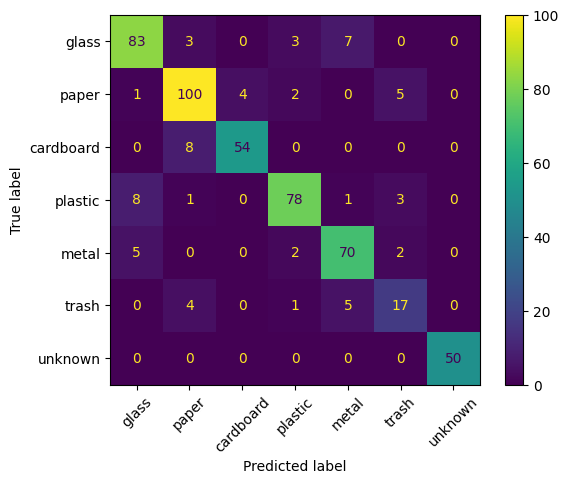

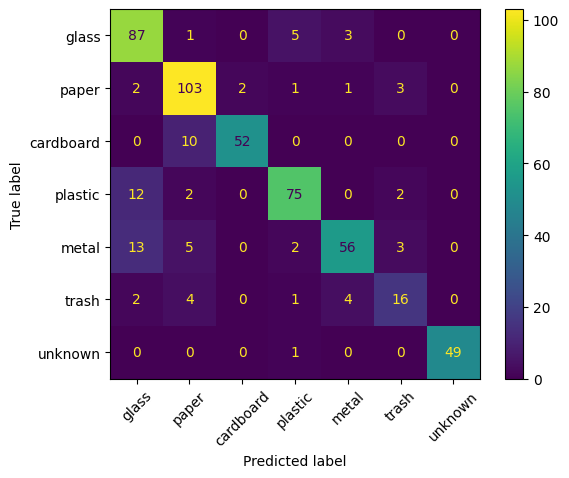

In [54]:

cm = confusion_matrix(test_labels, svc_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(xticks_rotation=45)
plt.show()


cm = confusion_matrix(test_labels, knn_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot(xticks_rotation=45)
plt.show()

In [ ]:
# create this pipeline for future use
svc_pipeline = Pipeline([
    ('feature_extractor', CNNFeatureExtractor(img_size=image_size)),
    ('scaler', StandardScaler( random_state=42)),
    ('pca', PCA(n_components=230, random_state=42)),
    ('svc', SVC(kernel="rbf", C=5, gamma="scale",class_weight="balanced", random_state=42))
])
svc_pipeline.fit(train_files, train_labels)

CNN FeatureExtractor ready.


Exception ignored in: <function AtomicFunction.__del__ at 0x000002648E7A1F80>
Traceback (most recent call last):
  File "d:\installation\python\Lib\site-packages\tensorflow\python\eager\polymorphic_function\atomic_function.py", line 303, in __del__
    RUNTIME_FUNCTION_REFS.pop(key)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
knn_pipeline = Pipeline([
    ('feature_extractor', CNNFeatureExtractor(img_size=image_size)),
    ('scaler', StandardScaler(random_state=42)),
    ('pca', PCA(n_components=150, random_state=42)),
    ('knn', KNeighborsClassifier(
        n_neighbors=10,
        weights="distance",
        metric="euclidean",
        random_state=42
    ))      
])
knn_pipeline.fit(train_files, train_labels)

CNN FeatureExtractor ready.


,steps,"[('feature_extractor', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,img_size,"(224, ...)"
,batch_size,32
,copy,True
,with_mean,True
,with_std,True
,n_components,150
,copy,True


In [ ]:
# test the pipelines
svc_pipeline_preds_train = svc_pipeline.predict(train_files)
svc_pipeline_acc_train = accuracy_score(train_labels, svc_pipeline_preds_train)

svc_pipeline_preds_test = svc_pipeline.predict(test_files)
svc_pipeline_acc_test = accuracy_score(test_labels, svc_pipeline_preds_test)

knn_pipeline_preds_train = knn_pipeline.predict(train_files)
knn_pipeline_acc_train = accuracy_score(train_labels, knn_pipeline_preds_train)

knn_pipeline_preds_test = knn_pipeline.predict(test_files)
knn_pipeline_acc_test = accuracy_score(test_labels, knn_pipeline_preds_test)
print(f"SVC Pipeline Train Accuracy: {svc_pipeline_acc_train*100:.2f}%")
print(f"SVC Pipeline Test Accuracy: {svc_pipeline_acc_test*100:.2f}%")
print(f"KNN Pipeline Train Accuracy: {knn_pipeline_acc_train*100:.2f}%")
print(f"KNN Pipeline Test Accuracy: {knn_pipeline_acc_test*100:.2f}%")

SVC Pipeline Train Accuracy: 99.14%
SVC Pipeline Test Accuracy: 88.59%
KNN Pipeline Train Accuracy: 99.97%
KNN Pipeline Test Accuracy: 86.27%


In [ ]:

import joblib

os.makedirs("../models", exist_ok=True)

joblib.dump(svc_pipeline, "../models/svc_pipeline.pkl")
joblib.dump(knn_pipeline, "../models/knn_pipeline.pkl")

print("Models saved successfully!")


Models saved successfully!


In [ ]:

svc_pipeline_2 = joblib.load("../models/svc_pipeline.pkl")     # Replace with your path
knn_pipeline_2 = joblib.load("../models/knn_pipeline.pkl")   # Replace with your path